In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from model.map2vec import *
from utils.evaluation import *
from utils.dataset import MapDataFrameIterator

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

In [6]:
def train(model, dataloader, loss_function=nn.CrossEntropyLoss(),
          init_lr=0.1, epochs=100, lr_decay_epoch = 30,
          print_epoch = 10, gpu=False):

    # Cuda is not critical for this task with low dimensionol inputs
    if gpu and torch.cuda.is_available():
        model.cuda()

    losses = []
    for epoch in range(epochs):

        # learning rate decay
        div, mod = divmod(epoch, lr_decay_epoch)
        if mod == 0:
            optimizer = optim.SGD(model.parameters(), lr=init_lr*(0.1)**div)

        total_loss = torch.Tensor([0])

        # iterate the dataset to load context heroes(team) and center hero(target)
        for teams, targets in dataloader:

            if gpu and torch.cuda.is_available():
                teams = teams.cuda()
                targets = targets.cuda()

            # wrap the embeddings of the team and target center hero to Variable
            inputs = autograd.Variable(teams)
            targets = autograd.Variable(targets.view(-1))

            # zero out the accumulated gradients
            model.zero_grad()

            # Run the forward pass
            out = model(inputs)

            # Compute your loss function.
            loss = loss_function(out, targets)

            # backpropagate and update the embeddings
            loss.backward()
            optimizer.step()

            # record total loss in this epoch
            total_loss += loss.cpu().data

        if epoch % print_epoch == 0:
            print('epoch: %d, loss: %.3f' % (epoch, total_loss/len(dataloader)))

        losses.append(total_loss/len(dataloader))
    # return losses for plot
    return np.array(losses)

def save_embeddings_map(model, filename = 'map_embeddings.npy'):
    embeddings = model.map_embeddings.weight.cpu().data.numpy()
    np.save(file = filename, arr=embeddings)

In [18]:
def main():

    data_dir = './input/map_teams.csv'
    hero2ix_dir = './input/hero2ix.csv'
    map2ix_dir = './input/map2ix.csv'

    # import DataFrame and
    df = pd.read_csv(data_dir, index_col=0)
    df = df.dropna().reset_index(drop=True)

    # hero2ix dictionary
    hero2ix_df = pd.read_csv(hero2ix_dir, index_col=0)
    hero2ix = dict(zip(hero2ix_df.hero, hero2ix_df.ID))

    # map2ix dictionary
    map2ix_df = pd.read_csv(map2ix_dir, index_col=0)
    map2ix = map2ix = dict(zip(map2ix_df.map, map2ix_df.ID))

    # train test split
    split = int(len(df)*0.9)
    map_train = df.iloc[:split]
    map_test = df.iloc[split:]

    # build dataset generator
    train_gen = MapDataFrameIterator(map_train, hero2ix, map2ix)
    test_gen = MapDataFrameIterator(map_test, hero2ix, map2ix)

    # Use Dataloader class in pytorch to generate batched data
    batch_size = 16
    loader_train = DataLoader(train_gen, batch_size=batch_size,
                              sampler=sampler.RandomSampler(train_gen),
                              num_workers=4)
    loader_test = DataLoader(test_gen, batch_size=batch_size,
                              sampler=sampler.SequentialSampler(test_gen),
                              num_workers=4)

    hero_emb_dir = './output/hero/hero_embeddings.npy'
    # define model, totally two models in map2vec.py
    assert os.path.isfile(hero_emb_dir), "hero_embeddings.npy doesn't exist"

    hero_embeddings = np.load(hero_emb_dir)
    model = CBOMTrilayer(hero_embeddings=hero_embeddings, mappool_size=len(map2ix),
                         map_embedding_dim=10, hidden_dim=40)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # run train
    losses = train(model=model, dataloader=loader_train, loss_function=loss_function,
                   init_lr=0.1, epochs=20, lr_decay_epoch=8, print_epoch=2, gpu=False)

    # check test accuracy
    print('accuracy: ', accuracy(model, dataloader=loader_test,
                                 batch_size=batch_size, gpu=False))

    # save embeddings as numpy arrays
    output_dir = './output/map/map_embeddings.npy'
    save_embeddings_map(model, filename=output_dir)

    # plot loss vs epoch
    plot_loss(losses, './output/map/loss_hitory.png')

    # project embeddings to 2d plane
    plot_embeddings_map(model, map2ix)

epoch: 0, loss: 3.470
epoch: 2, loss: 3.170
epoch: 4, loss: 3.125
epoch: 6, loss: 3.102
epoch: 8, loss: 3.059
epoch: 10, loss: 3.049
epoch: 12, loss: 3.046
epoch: 14, loss: 3.043
epoch: 16, loss: 3.037
epoch: 18, loss: 3.036
accuracy:  0.1423611111111111


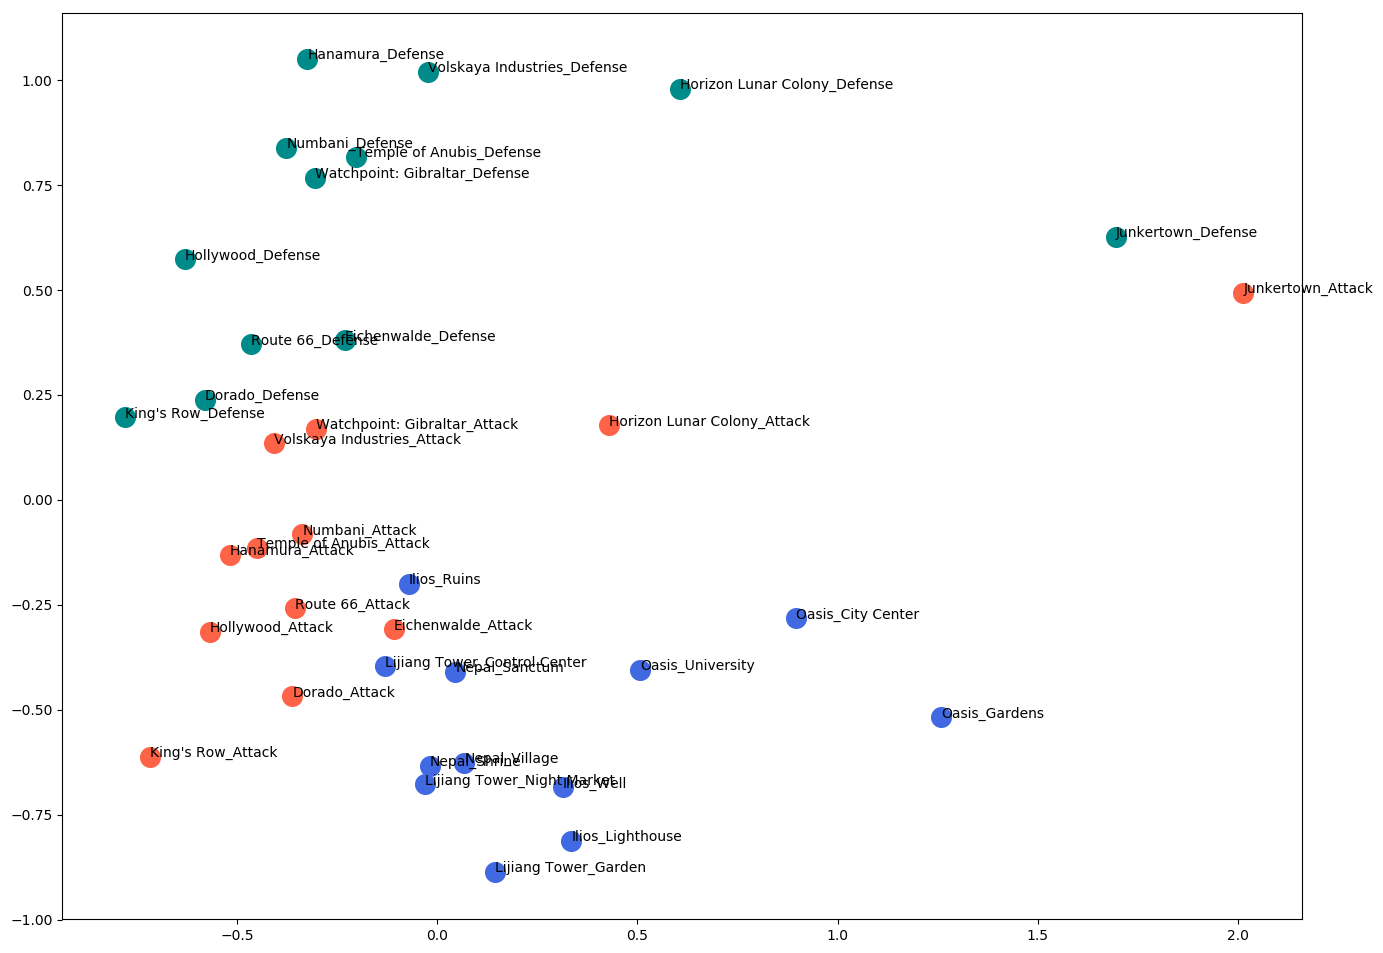

In [19]:
if __name__ == '__main__':
    main()